In [1]:
import os,sys
import pickle
import numpy as np                                       # fast vectors and matrices
from glob import glob
from time import time
import tensorflow as tf
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import shutil

'''
import matplotlib.pyplot as plt                          # plotting
from scipy.fftpack import fft
from sklearn.metrics import average_precision_score
'''
%matplotlib inline

In [2]:
sys.path.insert(0,'library\\')
import config
import diagnostics
import base_model   

Instructions for updating:
non-resource variables are not supported in the long term


## Data Loader

In [3]:
train_feat_path="processed_dataset\\train\\feat\\"
train_label_path="processed_dataset\\train\\label\\"
test_feat_path="processed_dataset\\test\\feat\\"
test_label_path="processed_dataset\\test\\label\\"

train_name=os.listdir(train_feat_path)
test_name=os.listdir(test_feat_path)

In [4]:
class CustomTrainDataset(Dataset):
    def __init__(self, feat_path=train_feat_path , label_path=train_label_path , transform=None, target_transform=None):
        self.img_labels = os.listdir(train_feat_path)
        self.feat_path = feat_path 
        self.label_path = label_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        data = (torch.from_numpy(np.load(self.feat_path +self.img_labels[idx])))
        label = (torch.from_numpy(np.load(self.label_path +self.img_labels[idx])))
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

class CustomTestDataset(Dataset):
    def __init__(self, feat_path=test_feat_path , label_path=test_label_path , transform=None, target_transform=None):
        self.img_labels = os.listdir(train_feat_path)
        self.feat_path = feat_path 
        self.label_path = label_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        data = (torch.from_numpy(np.load(self.feat_path +self.img_labels[idx])))
        label = (torch.from_numpy(np.load(self.label_path +self.img_labels[idx])))
        print(self.feat_path +self.img_labels[idx])
        return data, label
    
    def demo() :
        for indices in train :
            yield collate_fn(train_dataset[i] for i in indices)


In [5]:
train_dataset=CustomTrainDataset()
test_dataset=CustomTrainDataset()

In [6]:
from torch.utils.data import DataLoader

train = DataLoader(train_dataset, batch_size=32, shuffle=True)
test = DataLoader(train_dataset, batch_size=32, shuffle=True)

## model

In [15]:
import torch
from torch import tensor
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.core.debugger import set_trace
#from fastai import datasets
import pickle, gzip, math, torch
import operator

In [12]:
def normalize(x, m, s): 
    return (x-m)/s

In [201]:
class Model(nn.Module):
    # number of input feature, number of hidden feature, number of output feature
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        #self.fc = (32, 1500*120)
        #self.fc = (1500, 120)
        # data size = 32, 1500, 120
#         set_trace()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)] 
        print(self.layers)       
    def __call__(self, x):
        for k in self.layers:
            x = k(x)
        return x

In [260]:
# loss function
loss_func = F.cross_entropy
def accuracy(yhat, y):
    return (torch.argmax(yhat, dim=-1) == torch.argmax(y, dim=-1)).float().mean()
    #return (torch.argmax(yhat, dim=-1) == y).float().mean()

In [166]:
# batch size
bs = 64
# learning rate
lr = 0.03
epoch = 1
nh = 50

In [246]:
d,l =next(iter(train))

In [264]:
c = l.max()
k, m=d[1].size()

In [265]:
model = Model(m, nh, l.size(dim=2)) #model = Model(120, nh, l.size(dim=2))

[Linear(in_features=120, out_features=120, bias=True), ReLU(), Linear(in_features=120, out_features=88, bias=True)]


In [266]:
preds = model(d)
#preds[0]

In [267]:
loss = loss_func(preds, l)
acc = accuracy(preds, l)

In [268]:
loss , acc

(tensor(360.9875, grad_fn=<DivBackward1>), tensor(0.0026))

## loop

In [269]:
losses, metrics = [], []
epoch = 32

In [280]:
from torch.utils.data import DataLoader
train = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [281]:
epoch = train.__len__()
batch = 32

In [282]:
for e in range(epoch):
    # b = batch number
    #for b in range((n-1)//bs + 1):
    for b in range(0,batch):
        
        # Feedforward
        xb,yb =next(iter(train))
        yhatb = model(xb)
        loss = loss_func(yhatb, yb)

        # Metrics
        acc = accuracy(yhatb, yb)
        losses.append(loss); metrics.append(acc)
        
        # Backpropagation
        loss.backward()
        
        # Update Wight and Bias with SGD
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad * lr 
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [298]:
type(losses), type(metrics)

(list, list)

In [312]:
losses[0]

tensor(418.7771, grad_fn=<DivBackward1>)

In [314]:
tensor.detach().numpy()

AttributeError: 'builtin_function_or_method' object has no attribute 'detach'

In [321]:
losses[0].detach()

tensor(418.7771)

In [334]:
temp_l, temp_acc=[],[]
for k in losses :
    temp_l.append(k.detach())

for k in metrics :
    temp_acc.append(k.detach())

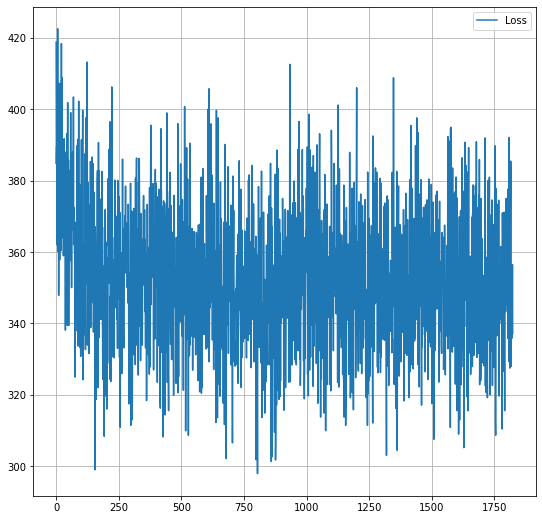

In [338]:
x = torch.arange(len(losses)).numpy()
fig,ax = plt.subplots(figsize=(9, 9))
ax.grid(True)
ax.plot(x, temp_l, label="Loss")
ax.legend(loc='upper right')

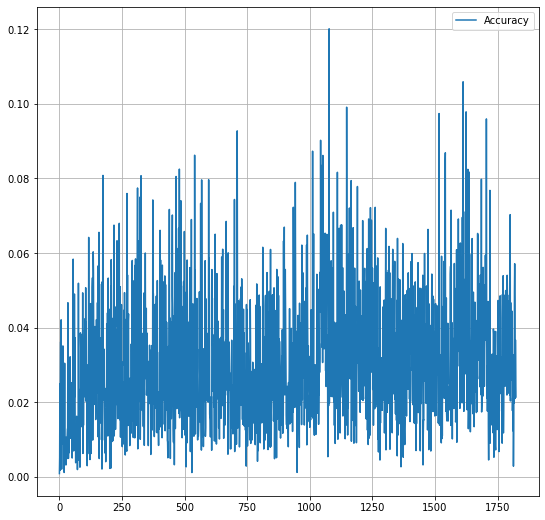

In [339]:
x = torch.arange(len(losses)).numpy()
fig,ax = plt.subplots(figsize=(9, 9))
ax.grid(True)
ax.plot(x, temp_acc, label="Accuracy")
ax.legend(loc='upper right')

In [340]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(334.1838, grad_fn=<DivBackward1>), tensor(0.0216))

## lookup

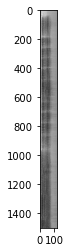

In [44]:
import matplotlib.pyplot as plt
plt.imshow(d[10], cmap=plt.cm.binary)

In [45]:
print(l[10])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
